## Прикладная статистика в машинном обучении

### Семинар 14. Байесовские методы. Продолжение.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats 

In [4]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [5]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.distributions import ImproperUniform, constraints

#### Задание 0. Теория.

Основа основ -- формула Байеса:

$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}.
$$

"Апостериорное распределение вектора параметров пропорционально произведению функции правдоподобия и априорного распределения параметров."

**Простой дискретный пример.**

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася. 

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.


$\hat{p}_c = 4/10$.

b) Теперь будем рассуждать с позиций байесовского подхода. Выпишите априорное распределение вероятности встретить карася $p_с$ и функцию правдоподобия.

$$
\theta := p_c
$$

$$
p(\theta) = \begin{cases}
1/2, \theta = 1/3, \\
1/2, \theta = 2/3.
\end{cases}
$$

$$
p(x | \theta) = p_с^{4}(1-p_с)^{6}.
$$

c) Выпишите апостериорное распределение $\theta$ с точностью до константы.

$$
p(\theta = 1/3| x) \propto (1/3)^4(2/3)^6 \frac{1}{2}
$$

$$
p(\theta = 2/3| x) \propto (2/3)^4(1/3)^6 \frac{1}{2}
$$

d) Рассчитайте апостериорное распределение $\theta$.

In [49]:
p1 = (1/3) ** 4 * (2/3) ** 6 * 1/2

In [50]:
p2 = (2/3) ** 4 * (1/3) ** 6 * 1/2

In [51]:
p1 / (p1 + p2)

0.8

In [52]:
p2 / (p1 + p2)

0.2

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

1. Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [37]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.34


array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0])

2. Задайте вероятностную модель.

In [42]:
def model(y):
    p = numpyro.sample('share', dist.Uniform(0, 1))
    y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs = y)

3. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [43]:
kernel = NUTS(model) # NUTS sampler 
mcmc = MCMC(kernel, 100, 500)
mcmc.run(random.PRNGKey(0), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 600/600 [00:09<00:00, 64.95it/s, 3 steps of size 6.78e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.34      0.05      0.34      0.27      0.43    136.38      1.00

Number of divergences: 0


(array([  4.,  18.,  37.,  69.,  88., 109.,  86.,  56.,  24.,   9.]),
 array([0.19390741, 0.22189325, 0.24987909, 0.27786493, 0.30585077,
        0.33383662, 0.3618225 , 0.38980833, 0.41779417, 0.44578   ,
        0.47376585], dtype=float32),
 <a list of 10 Patch objects>)

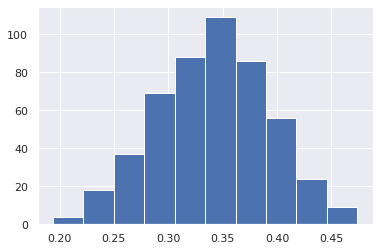

In [46]:
plt.hist(samples_1['share'])

#### Задание 2. Структурный сдвиг.

Предположим, что следующая выборка представляет собой набор данных по числу аварий в шахтах. 

In [66]:
years = np.arange(1800, 2000)
casual_1 = stats.poisson(3).rvs(100)
casual_2 = stats.poisson(1).rvs(100)
casual = np.hstack((casual_1, casual_2))

In [69]:
df = pd.DataFrame({'year' : years, 'casualties' : casual})
df

,year,casualties
0,1800,1
1,1801,1
2,1802,5
3,1803,3
4,1804,7
...,...,...
195,1995,1
196,1996,0
197,1997,2
198,1998,3


Text(0.5, 0, 'Year')

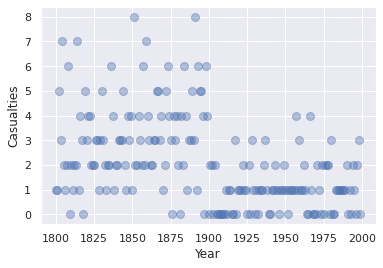

In [71]:
plt.plot(df.year, df.casualties, "o", markersize = 8, alpha=0.4)
plt.ylabel("Casualties")
plt.xlabel("Year")

In [72]:
y = casual

Будем считать, что $x_i \sim \mathrm{Pois}(\lambda)$, где 

$$
\lambda = \begin{cases}
\lambda_1, t < \tau, \\
\lambda_2, t \ge \tau
\end{cases}
$$

Априорное распределение на $\lambda$ задаётся следующим образом: $\lambda_i \sim \mathrm{Exp}(\alpha)$, где $\alpha$ -- некоторый гиперпараметр.

а) Оцените $\alpha$ на основе выборки. Так делать не честно, но так делают.

In [74]:
alpha = 1 / np.mean(y)
alpha

0.4807692307692307

b) Задайте вероятностную модель.

In [227]:
def model(y):
    tau = numpyro.sample('tau', dist.Uniform(years.min(), years.max()))
    early_rate = numpyro.sample('early_rate', dist.Exponential(rate = alpha))
    late_rate = numpyro.sample('late_rate', dist.Exponential(rate = alpha))
    
    rate = early_rate
    print(type(tau))
    
    y_obs = numpyro.sample('obs', dist.Poisson(rate), obs = y)

In [228]:
kernel = NUTS(model) # NUTS sampler 
mcmc = MCMC(kernel, 100, 500)
mcmc.run(random.PRNGKey(0), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

<class 'jax.interpreters.xla.DeviceArray'>
<class 'jax.interpreters.ad.JVPTracer'>


  0%|          | 0/600 [00:00<?, ?it/s]

<class 'jax.interpreters.ad.JVPTracer'>


warmup:   0%|          | 1/600 [00:04<49:37,  4.97s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

<class 'jax.interpreters.ad.JVPTracer'>


sample: 100%|██████████| 600/600 [00:13<00:00, 44.23it/s, 7 steps of size 5.55e-01. acc. prob=0.95] 


<class 'jax.interpreters.partial_eval.DynamicJaxprTracer'>

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  early_rate      2.08      0.10      2.08      1.89      2.23    498.16      1.00
   late_rate      2.13      2.37      1.36      0.01      5.24    465.13      1.00
         tau   1898.89     57.08   1899.16   1808.91   1983.89    415.73      1.00

Number of divergences: 0


In [17]:
import pymc3 as pm
import arviz as az

In [208]:
with pm.Model() as disaster_model:
    
    # априорные распределения для параметров: 
    tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())
    
    early_rate = pm.Exponential("early_rate", alpha)
    late_rate = pm.Exponential("late_rate", alpha)
    
    # разные значения lambda в зависимости от tau
    rate = pm.math.switch(tau >= years, early_rate, late_rate)
    
    # связь y с rate
    y_obs = pm.Poisson("disasters", rate, observed=y)

c) Оцените модель и получите приблизительное апостериорное распределение параметров.

In [209]:
with disaster_model:
    trace = pm.sample(1000, return_inferencedata=False, model=disaster_model)

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


d) Оцените вероятность того, что $\lambda_i$ различны.

In [210]:
np.mean(trace["early_rate"] - trace["late_rate"] > 0)

1.0

/home/vladimiromelyusik/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc44a109f10>,
      dtype=object)

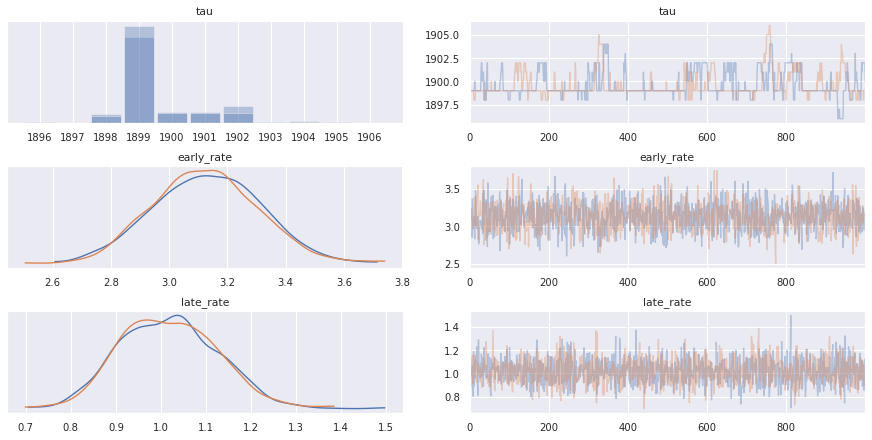

In [212]:
az.plot_trace(trace)

#### Пример. Байесовская регрессия.

В этом задании мы будем строить предсказательную байесовскую линейную регрессионную модель.

Исследуем набор данных `WaffleDivorce`, содержащий информацию о проценте разводов в 50 штатах США. 

In [6]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


Для построения модели отберём какие-нибудь из следующих регрессоров:
- `Population`
- `MedianAgeMarriage`
- `Marriage`
- `WaffleHouses`
- `South`.

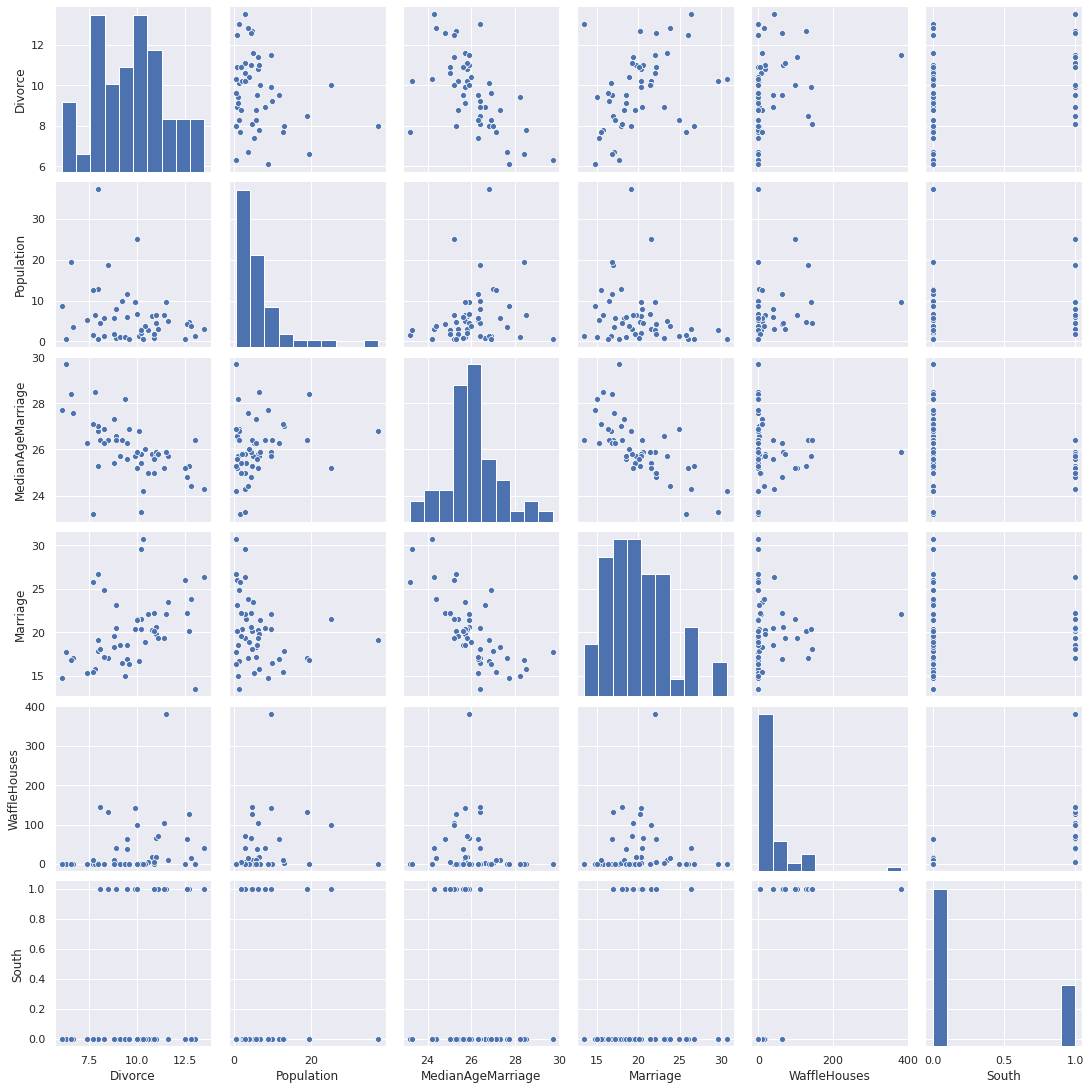

In [4]:
regr = ['Divorce', 'Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South']
sns.pairplot(dset, x_vars = regr, y_vars = regr)

Замечаем, что есть корреляция между:
- `Divorce` и `Marriage`.
- `Divorce` и `MedianAgeMarriage`.

и!
- `Divorce` и `WaffleHouses` (слабая).

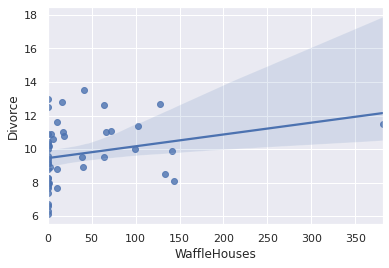

In [8]:
sns.regplot('WaffleHouses', 'Divorce', dset)

Это пример ложной корреляции: скорее всего, число `Waffle House` в штате не влияет на процент разводов, но может коррелировать с другими, влияющими, факторами (какими?). 

**Вывод:** для построения модели будем использовать `Marriage` и `MedianAgeMarriage` в качестве регрессоров.

In [19]:
X = dset[['Divorce', 'Marriage', 'MedianAgeMarriage']]

Стандартизируем переменные для лучшей сходимости.

In [20]:
stand = lambda x: (x - x.mean()) / x.std()
X = X.apply(stand)

Рассмотрим модель вида

$$
\mathrm{divorce} \sim \mathcal{N}(\mu, \sigma^2).
$$

$$
\mu = \beta_0 + \beta_1\mathrm{marriage} + \beta_2\mathrm{age}.
$$

В `numpyro` такую модель можно задать следующим образом:

In [23]:
def model(divorce = None, marriage = None, age = None):
    beta0 = numpyro.sample('beta0', dist.Normal(0, 0.2))
    MARRIAGE, AGE = 0, 0
    
    if marriage is not None:
        beta1 = numpyro.sample('beta1', ImproperUniform(constraints.real, (), event_shape=(1, 1)))
        #beta1 = numpyro.sample('beta1', dist.Normal(0, 0.5))
        MARRIAGE = beta1 * marriage
        
    if age is not None:
        beta2 = numpyro.sample('beta2', dist.Normal(0, 0.5))
        AGE = beta2 * age
    
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = beta0 + MARRIAGE + AGE
    numpyro.sample('obs', dist.Normal(mu, sigma), obs = divorce)

**Спецификация.** Используем в качестве регрессора только `marriage`.

In [24]:
kernel = NUTS(model) # NUTS sampler 
mcmc = MCMC(kernel, 1000, 2000)
mcmc.run(random.PRNGKey(0), marriage = X['Marriage'].values, divorce = X['Divorce'].values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:32<00:00, 91.66it/s, 7 steps of size 7.72e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0      0.00      0.11      0.00     -0.19      0.17   1711.73      1.00
beta1[0,0]      0.37      0.14      0.37      0.13      0.58   2008.33      1.00
     sigma      0.95      0.10      0.94      0.80      1.11   1774.15      1.00

Number of divergences: 0


[Text(0, 0.5, 'Divorce rate'),
 Text(0.5, 0, 'Marriage rate'),
 Text(0.5, 1.0, 'Regression line with 95% CI')]

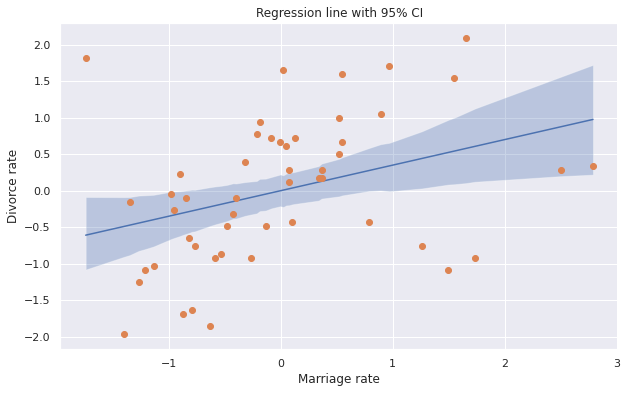

In [11]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = X['Divorce'].values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1['beta0'], -1) + \
               jnp.expand_dims(samples_1['beta1'], -1) * X['Marriage'].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(X['Marriage'].values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 95% CI')

**Пример. Семплировщик Метрополиса-Гастингса.**

In [16]:
# https://buildmedia.readthedocs.org/media/pdf/numpyro/stable/numpyro.pdf, с. 91
from collections import namedtuple
MHState = namedtuple("MHState", ["z", "rng_key"])

In [17]:
class MetropolisHastings(numpyro.infer.mcmc.MCMCKernel):
    sample_field = "z"
    
    def __init__(self, potential_fn, step_size = 0.1):
        self.potential_fn = potential_fn
        self.step_size = step_size
        
    def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
            return MHState(init_params, rng_key)
    
    def sample(self, state, model_args, model_kwargs): 
        z, rng_key = state
        rng_key, key_proposal, key_accept = random.split(rng_key, 3)
        z_proposal = dist.Normal(z, self.step_size).sample(key_proposal)
        
        accept_prob = jnp.exp(self.potential_fn(z) - self.potential_fn(z_proposal))
        
        z_new = jnp.where(dist.Uniform().sample(key_accept) < accept_prob, z_proposal, z)
        return MHState(z_new, rng_key)
    
def f(x):
    return((x - 2)**2).sum()

In [18]:
kernel = MetropolisHastings(f)
mcmc = MCMC(kernel, num_warmup = 1000, num_samples = 1000)
mcmc.run(random.PRNGKey(0), init_params = jnp.array([1., 2.]))
samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:04<00:00, 413.82it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      2.03      0.66      2.00      1.00      3.04      8.73      1.03
Param:0[1]      1.64      0.74      1.44      0.67      2.93      5.99      1.00



#### Источники мудрости.

[1] [Bayesian Regression Using NumPyro](http://num.pyro.ai/en/latest/tutorials/bayesian_regression.html)

[2] [MCMC](https://habr.com/ru/company/wunderfund/blog/279545/)